Number of samples: 3680
Extracting classes... (be patient)
Number of unique classes: 37


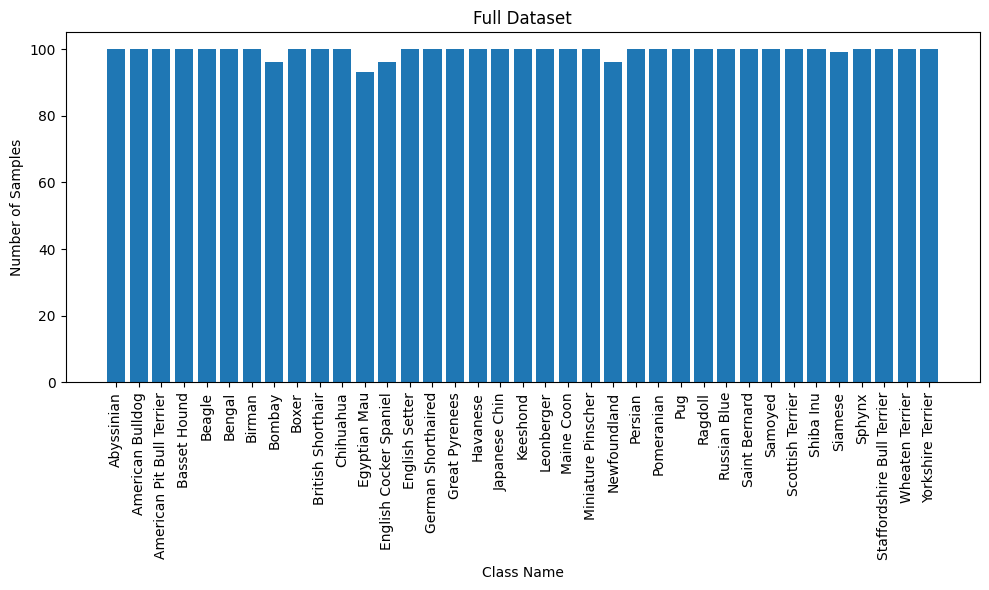

Number of samples: 800
Extracting classes... (be patient)
Number of unique classes: 17


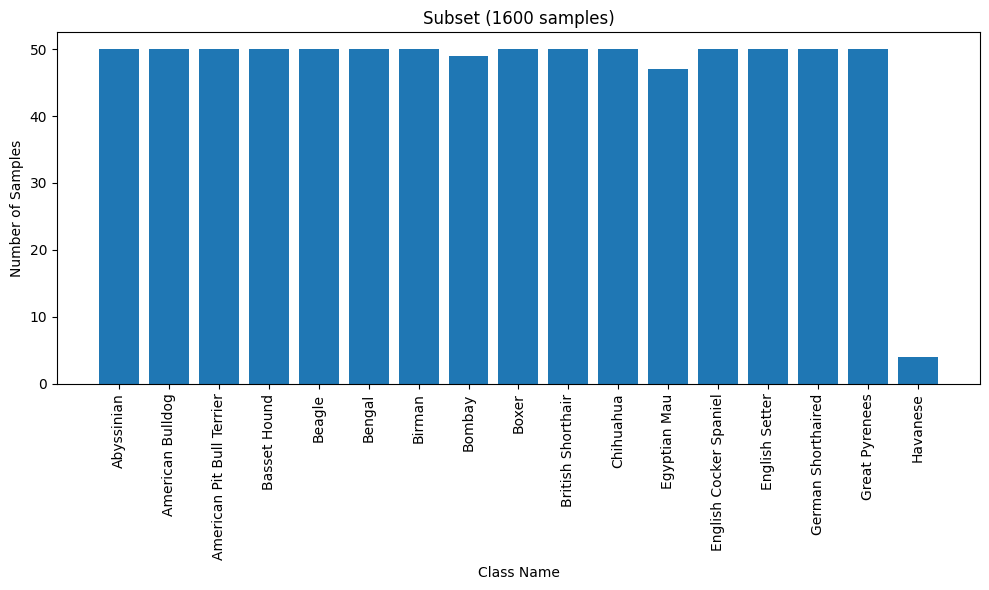

Number of samples: 100
Extracting classes... (be patient)
Number of unique classes: 2


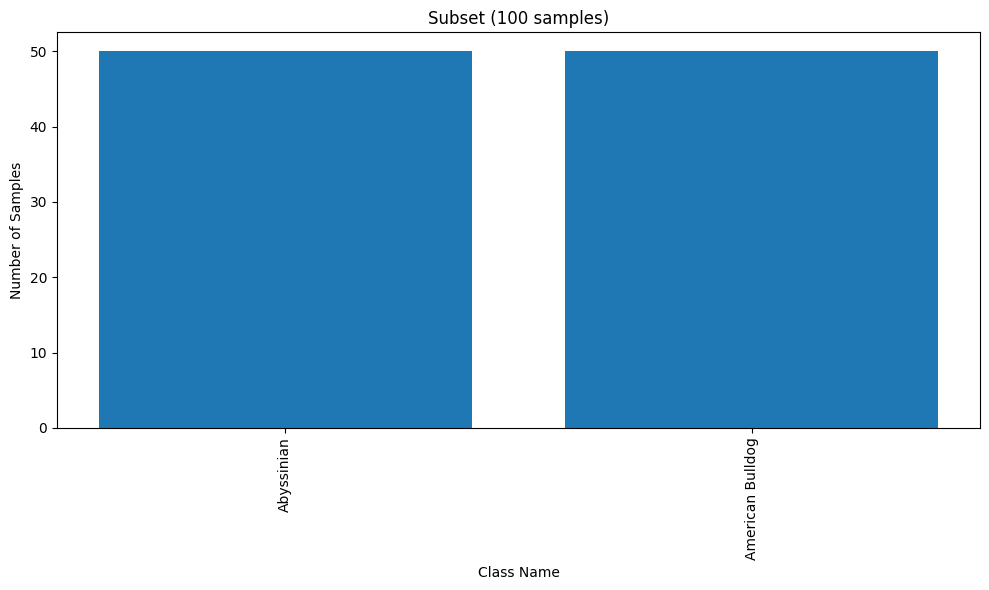

In [1]:
import torch
import matplotlib.pyplot as plt
from collections import Counter

from datasets import load_dataset

def plot_class_histogram(dataset, title="Class Distribution"):
    print(f"Number of samples: {len(dataset)}")
    print("Extracting classes... (be patient)")
    if isinstance(dataset, torch.utils.data.Subset):
        labels = [dataset.dataset[i][1] for i in dataset.indices]
        class_to_idx = dataset.dataset.class_to_idx
    else:
        labels = [dataset[i][1] for i in range(len(dataset))]
        class_to_idx = dataset.class_to_idx

    label_counts = Counter(labels)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in label_counts.keys()]
    num_classes = len(set(labels))
    print(f"Number of unique classes: {num_classes}")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, label_counts.values())
    plt.xlabel("Class Name")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
dataset = load_dataset("trainval", transform=None)
plot_class_histogram(dataset, title="Full Dataset")

dataset_1600 = torch.utils.data.Subset(dataset, range(800))
plot_class_histogram(dataset_1600, title="Subset (1600 samples)")

dataset_100 = torch.utils.data.Subset(dataset, range(100))
plot_class_histogram(dataset_100, title="Subset (100 samples)")
